In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Enrichment of proteins associated with circmCherry (Figure 3c)

## Preprocessing

In [6]:
d = pd.read_excel("data/240305_circmCherry_dataset.xlsx")
d = d[['Majority protein IDs', 
       'Unique peptides 1', 'Unique peptides 2', 'Unique peptides 3', 
       'Ratio H/L normalized 1', 'Ratio H/L normalized 2', 'Ratio H/L normalized 3']]
d.columns = ['Majority protein IDs', 
       'Unique peptides R1', 'Unique peptides R2', 'Unique peptides R3', 
       'Ratio H/L normalized R1', 'Ratio H/L normalized R2', 'Ratio H/L normalized R3']
print(d.shape)

fcs = [] # log2FC
pvals = [] # p-value
for rs in d[["Ratio H/L normalized R1", "Ratio H/L normalized R2", "Ratio H/L normalized R3"]].values:
    fcs.append(np.log2(np.mean(rs)))
    pvals.append(ttest_ind(rs, [1, 1, 1])[1])
d["Log2FC"] = fcs
d["Pvalue"] = pvals

rows = []
for i in range(d.shape[0]):
    row = d.iloc[i]
    for s in row["Majority protein IDs"].split(";"):
        try:
            if s.startswith("sp|"):
                entry = s.split("|")[1]
                row2 = row.copy()
                row2.name = entry
                rows.append(row2)
        except IndexError:
            continue
d = pd.DataFrame(rows)
d.index.name = "Entry"
print(d.shape)

# FDR
tmp = d[(d["Unique peptides R1"] >= 2) \
    & (d["Unique peptides R2"] >= 2) \
    & (d["Unique peptides R3"] >= 2) \
    & (~d["Ratio H/L normalized R1"].isna()) \
    & (~d["Ratio H/L normalized R2"].isna()) \
    & (~d["Ratio H/L normalized R3"].isna())].copy()
print("Filtered entries:", tmp.shape)
rejected, corrected_p_values, _, _ = multipletests(tmp["Pvalue"], alpha=0.05, method='fdr_bh')
mapper = {k: v for k, v in zip(tmp.index, corrected_p_values)}
d["FDR"] = d.index.map(mapper)

d.to_csv("results/Proteomic_circmCherry.csv")

(1549, 7)
(1693, 9)
Filtered entries: (664, 9)


## Plotting

(1693, 10)
(716, 10)
Q96NC0	ZMAT2	ZMAT2	1.000216	2.370102
P31942	HNRH3	HNRNPH3	0.852478	1.558446
P38159	RBMX	RBMX	0.839153	1.455403
P35637	FUS	FUS	0.839986	1.407785
P61978	HNRPK	HNRNPK	0.943934	2.369288
O95391	SLU7	SLU7	0.732978	1.455403
P09651	ROA1	HNRNPA1	0.910195	2.651676


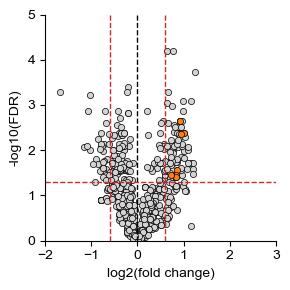

In [7]:
d = pd.read_csv("results/Proteomic_circmCherry.csv", index_col=0)
print(d.shape)
for r in [1, 2, 3]:
    d = d[d["Unique peptides R%d" % r] >= 2]
print(d.shape)

xs = d["Log2FC"]
ys = -np.log10(d["FDR"])
plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, marker="o", edgecolor="black", color="lightgrey", s=20, lw=0.5)
plt.xlabel("log2(fold change)")
plt.ylabel("-log10(FDR)")
plt.xlim(-2, 3)
plt.ylim(0, 5)
for loc in ["top","right"]:
    plt.gca().spines[loc].set_visible(False)
plt.axvline(np.log2(1.5), color="C3", ls="--", lw=1)
plt.axvline(-np.log2(1.5), color="C3", ls="--", lw=1)
plt.axvline(0, color="black", ls="--", lw=1)
plt.axhline(-np.log10(0.05), color="C3", ls="--", lw=1)

entries = [
    ["Q96NC0", "ZMAT2", "ZMAT2"],
    ["P31942", "HNRH3", "HNRNPH3"],
    ["P38159", "RBMX", "RBMX"],
    ["P35637", "FUS", "FUS"],
    ["P61978", "HNRPK", "HNRNPK"],
    ["O95391", "SLU7", "SLU7"],
    ["P09651", "ROA1", "HNRNPA1"]
]
for e in entries:
    tmp = d.loc[e[0]]
    x, y = tmp["Log2FC"], -np.log10(tmp["FDR"])
    print(e[0], e[1], e[2], round(x, 6), round(y, 6), sep="\t")
    plt.scatter(x, y, marker="o", edgecolor="black", color="C1", s=20, lw=0.5)
plt.tight_layout()
plt.savefig("figures/Proteomic_circmCherry.scatter.pdf")
plt.show()
plt.close()

# GO term analyis of enriched proteins (Figure 3d)

In [16]:
# Report circmCherry-interacting proteins

d1 = pd.read_csv("results/Proteomic_circmCherry_hits.csv", index_col=0)
d1 = d1[(d1["Log2FC"] >= np.log2(1.5)) & (d1["Pvalue"] < 0.05)]
print(d1.shape)
d2 = pd.read_csv("/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.gene_info.csv")
gnames2 = set(d2["GeneName"])
genelist = []
for gnames in d1["Gene Names"]:
    gnames1 = gnames.split()
    gnames3 = list(filter(lambda x: x in gnames2, gnames1))
    genelist.append(gnames3[0])
print(len(genelist))

with open("results/enriched_proteins_at_circmCherry.genelist.txt", "w+") as fw:
    fw.write("\n".join(genelist) + "\n")

(100, 16)
100


In [18]:
# Run GO term analysis at https://www.geneontology.org/ and download the results

d1 = pd.read_csv("data/goterms/circmCherry_hits_bp.txt", sep="\t", header=6)
d1.columns = ["GO", "REFLIST", "Upload", "Upload_Expected", "Over/Under", "Fold Enrichment", "P-value", "FDR"]
d1["Group"] = "biological process"

d2 = pd.read_csv("data/goterms/circmCherry_hits_mf.txt", sep="\t", header=6)
d2.columns = ["GO", "REFLIST", "Upload", "Upload_Expected", "Over/Under", "Fold Enrichment", "P-value", "FDR"]
d2["Group"] = "molecular function"

d3 = pd.read_csv("data/goterms/circmCherry_hits_cc.txt", sep="\t", header=6)
d3.columns = ["GO", "REFLIST", "Upload", "Upload_Expected", "Over/Under", "Fold Enrichment", "P-value", "FDR"]
d3["Group"] = "cellular component"

m = pd.concat([d1, d2, d3])
m.to_csv("results/circmCherry_hits_goterms.csv", index=False)

Index(['RNA localization (GO:0006403)',
       'protein-RNA complex assembly (GO:0022618)',
       'mRNA processing (GO:0006397)', 'RNA splicing (GO:0008380)',
       'RNA processing (GO:0006396)', 'RNA binding (GO:0003723)'],
      dtype='object', name='GO')


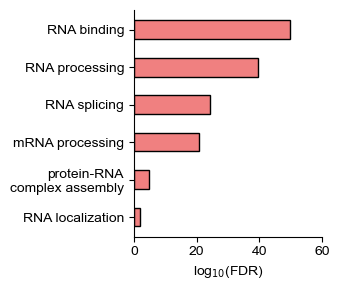

In [19]:
# Plot the GO term results

m = pd.read_csv("results/circmCherry_hits_goterms.csv", index_col=0)

terms = [
    "protein-RNA complex assembly (GO:0022618)",
    "RNA splicing (GO:0008380)",
    "mRNA processing (GO:0006397)",
    "RNA processing (GO:0006396)",
    "RNA localization (GO:0006403)",
    "RNA binding (GO:0003723)",
]
m = m.loc[terms]
m.sort_values(by="FDR", ascending=False, inplace=True)
ticks = m.index
print(ticks)
ticks = [
    'RNA localization',
    'protein-RNA\ncomplex assembly',
    'mRNA processing', 
    'RNA splicing',
    'RNA processing', 
    'RNA binding'
]

ys = np.arange(m.shape[0])
xs = -np.log10(m["FDR"])
plt.figure(figsize=(3.5, 3))
plt.barh(ys, xs, color="lightcoral", edgecolor="black", height=0.5)
plt.xlim(0, 60)
plt.xlabel("log$_{10}$(FDR)")
plt.yticks(ys, ticks)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/circmCherry_hits_goterms.pdf")


In [20]:
m

,REFLIST,Upload,Upload_Expected,Over/Under,Fold Enrichment,P-value,FDR,Group
GO,,,,,,,,
RNA localization (GO:0006403),190,7,0.93,+,7.51,4.240000e-05,1.520000e-02,biological process
protein-RNA complex assembly (GO:0022618),193,10,0.95,+,10.56,3.820000e-08,1.850000e-05,biological process
mRNA processing (GO:0006397),459,29,2.25,+,12.87,2.090000e-24,2.420000e-21,biological process
RNA splicing (GO:0008380),375,30,1.84,+,16.3,2.660000e-28,4.000000e-25,biological process
RNA processing (GO:0006396),870,52,4.27,+,12.18,2.200000e-44,3.310000e-40,biological process
RNA binding (GO:0003723),1675,71,8.22,+,8.64,4.210000e-54,2.150000e-50,molecular function


# Proteomic of Endogenous circRNA (Extended Data Figure 6f)

In [4]:
d = pd.read_excel("data/endogenous_circRNA.xlsx", index_col=0)
d.index.name = "Entry"
d = d[["C", "C.1", "C.2", "M", "M.1", "M.2"]]
d.columns = ["C1", "C2", "C3", "M1", "M2", "M3"]
d["C.Mean"] = d[["C1", "C2", "C3"]].mean(axis=1)
d["M.Mean"] = d[["M1", "M2", "M3"]].mean(axis=1)
d["Log2FC"] = (d["M.Mean"] - d["C.Mean"])
pvals = []
for vs in d[["C1", "C2", "C3", "M1", "M2", "M3"]].values:
    pvals.append(ttest_ind(vs[0:3], vs[3:6])[1])
d["Pvalue"] = pvals

# FDR
rejected, corrected_p_values, _, _ = multipletests(d["Pvalue"], alpha=0.05, method='fdr_bh')
d["FDR"] = corrected_p_values

anno = pd.read_csv("../../common/uniprotkb/uniprotkb-245896766.human.tsv", sep="\t", index_col=0)
d = d.merge(anno, left_index=True, right_index=True)
print(d.shape)
d.to_csv("results/Proteomic_endogenous_circRNA.csv")

(1390, 17)


P46060	RANGAP1	1.8069	2.7002
Q7KZ85	SUPT6H	1.7074	1.4258
Q8N8A6	DDX51	1.414	1.3186
P07355	ANXA2	2.9056	1.5366


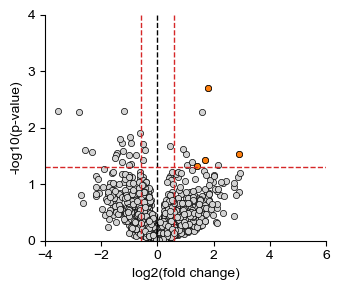

In [5]:
d = pd.read_csv("results/Proteomic_endogenous_circRNA.csv", index_col=0)
xs, ys = d["Log2FC"], -np.log10(d["Pvalue"])
plt.figure(figsize=(3.5, 3))
plt.scatter(xs, ys,marker="o", s=20, color="lightgrey", edgecolor="black", lw=0.5)
if True:
    entries = [
        ["P46060", "RANGAP1"],
        ["Q7KZ85", "SUPT6H"],
        ["Q8N8A6", "DDX51"],
        ["P07355", "ANXA2"],
    ]
    for e in entries:
        x = d.loc[e[0]]["Log2FC"]
        y = -np.log10(d.loc[e[0]]["Pvalue"])
        print(e[0], e[1], round(x, 4), round(y, 4), sep="\t")
        plt.scatter(x, y, marker="o", s=20, color="C1", label=e[1], edgecolor="black", lw=0.5)
plt.axvline(np.log2(1.5), color="C3", lw=1, ls="--")
plt.axvline(-np.log2(1.5), color="C3", lw=1, ls="--")
plt.axvline(0, color="black", lw=1, ls="--")
plt.axhline(-np.log10(0.05), color="C3", lw=1, ls="--")
plt.xlim(-4, 6)
plt.ylim(0, 4)
plt.yticks([0, 1, 2, 3, 4])
plt.xlabel("log2(fold change)")
plt.ylabel("-log10(p-value)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/endogenous_circRNA.pdf")
plt.show()
plt.close()